In [3]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import packages 
import sys
import pandas as pd
import seaborn as sns
from time import time
from pyspark.sql import Row
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit,CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml import Pipeline, PipelineModel
%matplotlib inline

In [3]:
# check env
!printenv|egrep "SPARK_HOME|PYSPARK_PYTHON|PYSPARK_DRIVER_PYTHON"

In [5]:
# create a spark session
spark = SparkSession.builder.getOrCreate()
# spark and python version
print(spark.version)
print(sys.version)

3.0.1
3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]


In [7]:
# dataset path
video_games = './reviews_Video_Games_5.json'
# create spark dataframe 
df_raw = spark.read.json(video_games)
# Show first two rows and display number of rows
df_raw.show(n=2)
df_raw.count()

+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|0700099867|[8, 12]|    1.0|Installing the ga...| 07 9, 2012|A2HD75EMZR8QLN|                 123|Pay to unlock con...|    1341792000|
|0700099867| [0, 0]|    4.0|If you like rally...|06 30, 2013|A3UR8NLLY1ZHCX|Alejandro Henao "...|     Good rally game|    1372550400|
+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
only showing top 2 rows



231780

In [8]:
# drop not needed columns
df = df_raw.drop('helpful','reviewText','reviewTime','reviewerName','unixReviewTime','summary')

# rename columns
df2 = df.selectExpr("asin","overall as rating", "reviewerID as user")
# shoe first 6 rows
df2.show(n=6)
# display data types and check if they are correct, e.g. rating should be double
df2.printSchema()

+----------+------+--------------+
|      asin|rating|          user|
+----------+------+--------------+
|0700099867|   1.0|A2HD75EMZR8QLN|
|0700099867|   4.0|A3UR8NLLY1ZHCX|
|0700099867|   1.0|A1INA0F5CWW3J4|
|0700099867|   3.0|A1DLMTOTHQ4AST|
|0700099867|   4.0|A361M14PU2GUEG|
|0700099867|   4.0|A2UTRVO4FDCBH6|
+----------+------+--------------+
only showing top 6 rows

root
 |-- asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- user: string (nullable = true)



In [9]:
# show summary
df2.describe().show()

+-------+-------------------+------------------+--------------------+
|summary|               asin|            rating|                user|
+-------+-------------------+------------------+--------------------+
|  count|             231780|            231780|              231780|
|   mean|7.198617864286957E9| 4.086396582966606|                null|
| stddev|3.628023820739709E9|1.2023296087789064|                null|
|    min|         0700099867|               1.0|A00263941WP7WCIL7...|
|    max|         B00KHECZXO|               5.0|       AZZTC2OYVNE2Q|
+-------+-------------------+------------------+--------------------+



In [10]:
# transform asin and user alphanumeric string to index using spark StringIndexer function
asinIndexer = StringIndexer(inputCol="asin", outputCol="item",handleInvalid='error') # create indexer for asins
userIndexer = StringIndexer(inputCol='user',outputCol='userid',handleInvalid='error') # create indexer for user
asinIndexed = asinIndexer.fit(df2).transform(df2) # apply asin indexer
userIndexed = userIndexer.fit(asinIndexed).transform(asinIndexed) # apply user indexer
df_indexed = userIndexed.drop('asin').drop('user') # remove old columns with alphanumeric strings

# 70-30 train-test split
(df_train, df_test) = df_indexed.randomSplit([0.7,0.3])
# cache them in memory across clusters since we access this data frequently 
df_train.cache() 
df_test.cache()

# Display dataset size
print('Train set size: {}'.format(df_train.count()))
print('Test set size: {}'.format(df_test.count()))

print('Matrix size, percentage of matrix filled and number of distinct users and itmes:')
# calculate percentage of the user-item matrix that is filled
df_train.createOrReplaceTempView('df_train')
spark.sql("""
      SELECT *, 100 * rating/matrix_size AS percentage
        FROM (
          SELECT userid, item, rating, userid * item AS matrix_size
            FROM(
              SELECT COUNT(*) AS rating, COUNT(DISTINCT(item)) AS item, COUNT(DISTINCT(userid)) AS userid
                FROM df_train
                )
            )
""").show()

Train set size: 162239
Test set size: 69541
Matrix size, percentage of matrix filled and number of distinct users and itmes:
+------+-----+------+-----------+-------------------+
|userid| item|rating|matrix_size|         percentage|
+------+-----+------+-----------+-------------------+
| 24277|10668|162239|  258987036|0.06264367611049072|
+------+-----+------+-----------+-------------------+



In [11]:
df_viz = df_indexed.sample(False,0.09) # sample a small portion of the dataset for visualization
pdf = df_viz.toPandas() # convert to pandas dataframe

/home/hdoop/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


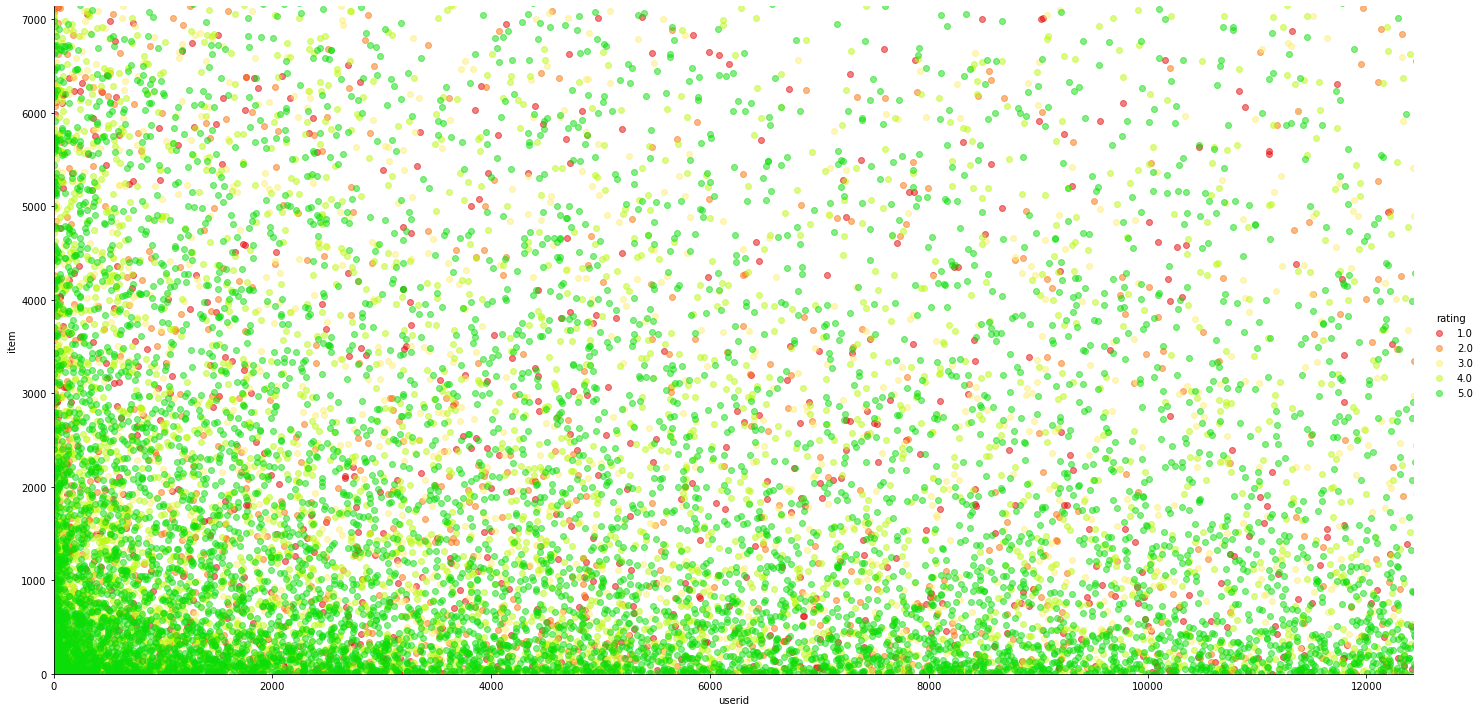

In [12]:
numuniquser = pdf['userid'].value_counts().count() # to set axis
numuniqitem = pdf['item'].value_counts().count() # to set axis
custompal = sns.xkcd_palette(['red', 'orange', 'sandy yellow', 'yellowgreen', 'vibrant green']) # traffic-light style palette
scplot = sns.lmplot('userid','item',pdf,hue='rating',fit_reg=False,size=10 # use seaborn lmplot to plot user vs item and rating as hue
           , aspect=2,palette=custompal,scatter_kws={'alpha':0.5})
axes = scplot.axes
axes[0,0].set_ylim(0,numuniqitem)  
axes[0,0].set_xlim(0,numuniquser) 
scplot
plt.savefig('scatterplot.png',dpi=50)

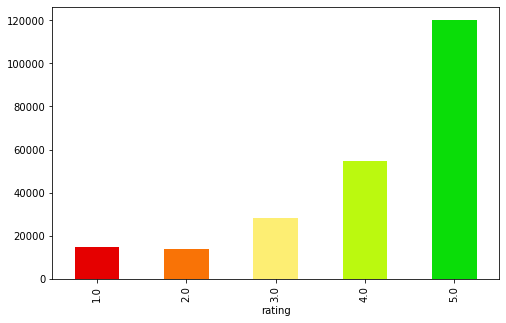

In [13]:
df_indexed.createOrReplaceTempView('df_ind') # create temp SQL view
# count number of ratings in each category 
ratingcount = spark.sql("""
      SELECT COUNT(rating) as count
      ,rating
      FROM df_ind
      GROUP BY rating
""")
pandas_rc = ratingcount.toPandas()  # convert to pandas
pandas_rc.sort_values('rating',axis=0,inplace=True) # sort 
pandas_rc.plot(x='rating',y='count',kind='bar',legend=False,color=custompal,figsize=(8,5)) # plot using the traffic-light palette
plt.savefig('barchart.png',dpi=70) # save to disk
plt.show()

In [14]:
pandas_rc

,count,rating
0,14853,1.0
3,13663,2.0
2,28275,3.0
1,54804,4.0
4,120185,5.0


In [15]:
mean = float(df_train.describe().toPandas()['rating'][1]) # mean
print('Training set mean: {}'.format(mean))
print('Test set baseline MSE and RMSE')     
se_rdd = df_test.rdd.map(lambda x: (x[0]-mean)**2) #  squared error
row = Row("val") # create row
se_df = se_rdd.map(row).toDF() # convert to df
se_df.createOrReplaceTempView('se_df') # create temp SQL view
baseline = spark.sql('SELECT AVG(val) as MSE,SQRT(AVG(val)) as RMSE  FROM se_df') # calculate MSE and RMSE
baseline.show()
baseline_rmse = float(baseline.toPandas()['RMSE'][0])

Training set mean: 4.085337064454293
Test set baseline MSE and RMSE
+----------------+------------------+
|             MSE|              RMSE|
+----------------+------------------+
|1.44567464193626|1.2023621093232522|
+----------------+------------------+



In [16]:
def als_pipeline(df_train,df_test,trainingdownsampling=0.99):
    """
      Args: 
        df_train: pyspark train dataframe  
        df_test: pyspark test dataframe
        trainingdownsampling: percentage of full training set
      Returns:
        testset_rmse
        baseline_rmse
        wallclock
    """

    # model
    als = ALS(userCol="userid", itemCol="item", ratingCol="rating",coldStartStrategy='drop',nonnegative=False)
    
    # evaluator
    rmseevaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

    # parameter grid
    paramGrid = ParamGridBuilder()\
        .addGrid(als.rank, [1, 5, 10,50,70]) \
        .addGrid(als.maxIter, [15])\
        .addGrid(als.regParam, [0.05, 0.1, 0.5,5])\
        .build()

    # train validation split
    tvs = TrainValidationSplit(estimator=als,
                               estimatorParamMaps=paramGrid,
                               evaluator=rmseevaluator,
                               trainRatio=0.8)

    
    # sample, Note : spark sample does is not guaranteed to provide exactly the fraction specified of the total
    training = df_train.sample(False,trainingdownsampling)
    print('Full training set size: {}'.format(df_train.count()))
    print('Downsampled training set size: {} \n'.format(training.count()))
  
    # fit model and time it
    print('Fitting model...')
    startTime = time()
    tvsmodel = tvs.fit(training)
    endTime = time()
    wallclock = ( endTime - startTime )
    
    print('Wall-clock time: {}'.format(wallclock))
    
    print('\n')
    paramMap = list(zip(tvsmodel.validationMetrics,tvsmodel.getEstimatorParamMaps())) # zip validation rmse and selected parameters
    paramMax = min(paramMap)
    print('Best parameters and validation set RMSE:')
    print(paramMax)
    print('\n')
    
    # predict and evaluate test set
    predictions = tvsmodel.transform(df_test)
    testset_rmse = rmseevaluator.evaluate(predictions)
    print('Test set RMSE: {}'.format(testset_rmse))    
    return testset_rmse,wallclock,paramMax

In [17]:
downsamples = [0.01,0.1,0.5,0.8] # list of percentages to downsample training set
rmses = [] 
wallclocks = []
params = []
# loop through the list and apply the pipeline function, append the results to the above empty lists
for s in downsamples:
    print('Fitting als model for {} % of the training set'.format(s*100))
    test_rmse,wallclock,parammax = als_pipeline(df_train,df_test,trainingdownsampling=s)
    rmses.append(test_rmse)
    wallclocks.append(wallclock)
    params.append(parammax)

Fitting als model for 1.0 % of the training set
Full training set size: 162239
Downsampled training set size: 1618 

Fitting model...
Wall-clock time: 1302.9218618869781


Best parameters and validation set RMSE:
(4.044428698230877, {Param(parent='ALS_7de1f59cb216', name='rank', doc='rank of the factorization'): 10, Param(parent='ALS_7de1f59cb216', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_7de1f59cb216', name='regParam', doc='regularization parameter (>= 0).'): 0.05})


Test set RMSE: 4.475605288775717
Fitting als model for 10.0 % of the training set
Full training set size: 162239
Downsampled training set size: 16192 

Fitting model...
Wall-clock time: 905.149608373642


Best parameters and validation set RMSE:
(4.122859486461798, {Param(parent='ALS_c628078b298a', name='rank', doc='rank of the factorization'): 50, Param(parent='ALS_c628078b298a', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_c628078b298a', name='regP

In [18]:
als = ALS(userCol="userid", itemCol="item", ratingCol="rating",coldStartStrategy='drop',nonnegative=False)
     
# evaluator
rmseevaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# parameter grid
paramGrid = ParamGridBuilder()\
    .addGrid(als.rank, [1, 5, 10,50,70]) \
    .addGrid(als.maxIter, [15])\
    .addGrid(als.regParam, [0.05, 0.1, 0.5,5])\
    .build()

# train validation split
tvs = TrainValidationSplit(estimator=als,
                           estimatorParamMaps=paramGrid,
                           evaluator=rmseevaluator,
                           trainRatio=0.8)
# fit model and time
startTime = time()
tvsmodel = tvs.fit(df_train)
endTime = time()
wallclock = ( endTime - startTime )
    
print('Wall-clock time: {}'.format(wallclock))
    
print('\n')
# zip train validation and parameter into one list
paramMap = list(zip(tvsmodel.validationMetrics,tvsmodel.getEstimatorParamMaps()))
paramMax = min(paramMap)
print(paramMax)

# predict and evaluate test set
predictions = tvsmodel.transform(df_test)
testset_rmse = rmseevaluator.evaluate(predictions)
print('Test set RMSE: {}'.format(testset_rmse))

Wall-clock time: 980.1181616783142


(1.2776001826744945, {Param(parent='ALS_c98a91a4631a', name='rank', doc='rank of the factorization'): 10, Param(parent='ALS_c98a91a4631a', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_c98a91a4631a', name='regParam', doc='regularization parameter (>= 0).'): 0.5})
Test set RMSE: 1.2264493464727597


In [54]:
rmses.append(testset_rmse)
wallclocks.append(wallclock)
params.append(paramMax)

In [55]:
rank1 = list(params[0][1].values())[0]
iter1 = list(params[0][1].values())[1]
reg1 = list(params[0][1].values())[2]

rank2 = list(params[1][1].values())[1]
iter2 = list(params[1][1].values())[2]
reg2 = list(params[1][1].values())[0]

rank3 = list(params[2][1].values())[0]
iter3 = list(params[2][1].values())[2]
reg3 = list(params[2][1].values())[1]

rank4 = list(params[3][1].values())[1]
iter4 = list(params[3][1].values())[0]
reg4 = list(params[3][1].values())[2]

rank5 = list(params[4][1].values())[0]
iter5 = list(params[4][1].values())[1]
reg5 = list(params[4][1].values())[2]

In [95]:
val_rmse = list(map(lambda x: x[0], params))
ranks = [rank1,rank2,rank3,rank4,rank5]
iters = [iter1,iter2,iter3,iter4,iter5]
regParams = [reg1,reg2,reg3,reg4,reg5]

In [96]:
downsamples = [0.01,0.1,0.5,0.8]
downsamples.append(1)
downsamples.append('')
downsamples.append('')
ranks.append('')
ranks.append('')
iters.append('')
iters.append('')
regParams.append('')
regParams.append('')

In [97]:
pd_results = pd.DataFrame(
    {'Downsample percentage': downsamples,
     'Number of latent factors': ranks,
     'Maximum number of iterations': iters,
     'Regularization parameter': regParams,
     'Wall-clock time': wallclocks,
     'Validation RMSE': val_rmse,
     'Test RMSE': rmses
    })

In [98]:
pd_results

,Downsample percentage,Number of latent factors,Maximum number of iterations,Regularization parameter,Wall-clock time,Validation RMSE,Test RMSE
0,0.01,10,15,0.05,1302.921862,4.044429,4.475605
1,0.1,15,0.5,50,905.149608,4.122859,3.992590
2,0.5,50,0.5,15,983.475603,1.563402,1.432021
3,0.8,15,50,0.5,1031.769011,1.332519,1.280109
4,1,10,15,0.5,980.118162,1.277600,1.226449
5,,,,,980.118162,1.277600,1.226449
6,,,,,980.118162,1.277600,1.226449


In [110]:
pd_results.drop([5,6])
pd_result=pd_results.iloc[0:4,:]
pd_result

,Downsample percentage,Number of latent factors,Maximum number of iterations,Regularization parameter,Wall-clock time,Validation RMSE,Test RMSE
0,0.01,10,15,0.05,1302.921862,4.044429,4.475605
1,0.1,15,0.5,50,905.149608,4.122859,3.992590
2,0.5,50,0.5,15,983.475603,1.563402,1.432021
3,0.8,15,50,0.5,1031.769011,1.332519,1.280109


In [107]:
pd_results.to_csv('results.csv')

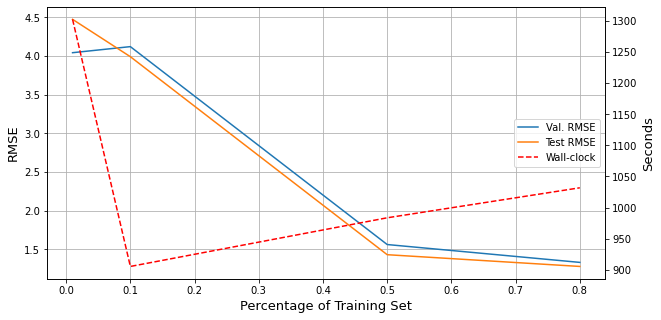

In [111]:
fig, ax1 = plt.subplots(figsize=(10,5))
x = pd_result['Downsample percentage']
y1 = pd_result['Validation RMSE']
y2 = pd_result['Test RMSE']
line1 = ax1.plot(x,y1,label= 'Val. RMSE')
line2 = ax1.plot(x,y2,label= 'Test RMSE')

ax2 = ax1.twinx()
y3 = pd_result['Wall-clock time']
line3 = ax2.plot(x,y3,'r--',label='Wall-clock')

# labeling

ys = line1+line2+line3
labels = [l.get_label() for l in ys]
ax1.legend(ys, labels, loc='center right')

ax1.grid()
ax1.set_xlabel('Percentage of Training Set',fontsize=13)
ax1.set_ylabel('RMSE',fontsize=13)
ax2.set_ylabel('Seconds',fontsize=13)
plt.savefig('results.png',dpi=70)
plt.show()

In [102]:
df_train.show(n=3)

+------+----+------+
|rating|item|userid|
+------+----+------+
|   1.0| 4.0| 138.0|
|   1.0| 4.0| 696.0|
|   1.0| 4.0|4179.0|
+------+----+------+
only showing top 3 rows



In [105]:
from pyspark.sql.functions import lit
from pyspark.ml.feature import IndexToString

def recommendGames(model, user, num_rec):
    # Create a dataset with distinct games as one column and the user of interest as another column
    itemsuser = df_train.select("item").distinct().withColumn("userid", lit(user))
    itemsuser.show(n=5)

    # filter out games that user has already rated 
    gamesrated = df_train.filter(df_train.userid == user).select("item", "userid")

    # apply trained recommender system
    predictions = model.transform(itemsuser.subtract(gamesrated)).dropna().orderBy("prediction", ascending=False).limit(num_rec).select("item", "prediction")
    predictions.show()
    
    # convert index back to original ASIN 
    converter = IndexToString(inputCol="item", outputCol="originalCategory")
    converted = converter.transform(predictions)
    converted.show()

In [106]:
recommendGames(tvsmodel,696,3)

+------+------+
|  item|userid|
+------+------+
| 934.0|   696|
|1761.0|   696|
|2815.0|   696|
|3901.0|   696|
|4142.0|   696|
+------+------+
only showing top 5 rows

+------+----------+
|  item|prediction|
+------+----------+
|5439.0| 4.8064504|
|9460.0|  4.767398|
|6987.0|  4.682905|
+------+----------+

+------+----------+----------------+
|  item|prediction|originalCategory|
+------+----------+----------------+
|5439.0| 4.8064504|      B004DGJP2G|
|9460.0|  4.767398|      B00005BYK3|
|6987.0|  4.682905|      B000JZ4EVW|
+------+----------+----------------+

